# Classification on BirdClef Dataset by using features from Whisper Encoder

In this notebook, we performed classification on BirdClef Dataset. The feature is extracted using Whisper encoder, which are then passed to different variation of CNN model to determine the species class.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import whisper
import random

In [2]:
# Setting seed
seed=42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

## Notebook Configuration

This notebook has 4 variations that it can run on, which are given as:
1. augmentedRun = True  + FTRun = True      : If you want to run the model on augmented dataset by fine tuning the model
2. augmentedRun = False + FTRun = True      : If you want to run the model on raw dataset by fine tuning the model
3. augmentedRun = True  + FTRun = False     : If you want to run the model on augmented dataset by not fine tuning the model
4. augmentedRun = False + FTRun = False     : If you want to run the model on raw dataset without fine tuning

needToMakePT = False : For model to run, we are passing mel spectrogram to the whisper encoder instead of audios. If you need to first convert the audios to mel spectrogram, pass True to the flag so on first run, it'll convert all audios to mel spectrogram and save it to torch file.

In [3]:
# Flag to run model for augmented dataset or raw dataset
augmentedRun = True
FTRun = True
randomWeight = False

# Prepare PT (Required 1st time only & you need to have original ogg audios)
# added this code so we can save time over the epoch by saving mel
needToMakePT = False

In [4]:
# Setting directory paths as per the configuration
if(augmentedRun):
    csvPath = "./dataset/pt_files/augmented.csv"
    audio_folder_path = './birdclef-2023/augmented_audio/' # not required to set if pt files are already there
    main_folder_path = "./dataset/pt_files/augmented/"
else:
    csvPath = "./dataset/pt_files/original.csv"
    audio_folder_path = './dataset/audio_files/original/' # not required to set if pt files are already there
    main_folder_path = "./dataset/pt_files/original/"

Set paths for the checkpoints and create folders if they don't exist

In [5]:
# Base directory for checkpoints
base_checkpoint_path = './checkpoints'

# Determine the folder names based on the flag states
config_name = f"{'dAugmented_' if augmentedRun else 'dOriginal'}" \
              f"{'mFineTuned_' if FTRun else 'mFrozen_'}" \
              f"{'wRandom' if randomWeight else 'wPretrained'}"

# Construct the full paths for train and test checkpoints
train_checkpoint_path = os.path.join(base_checkpoint_path, config_name, 'train')
test_checkpoint_path = os.path.join(base_checkpoint_path, config_name, 'test')

# Create the directories if they don't exist
os.makedirs(train_checkpoint_path, exist_ok=True)
os.makedirs(test_checkpoint_path, exist_ok=True)

## Loading Data to DataFrame

In [6]:
# Loading the file from the path as per the config
df = pd.read_csv(csvPath)
df.head()

,Label_Name,filename_pt
0,colsun2,colsun2/XC122411.pt
1,colsun2,colsun2/XC736024.pt
2,colsun2,colsun2/XC516528.pt
3,colsun2,colsun2/XC650873.pt
4,colsun2,colsun2/XC323386.pt


In [7]:
print(df.shape)

(28748, 2)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28748 entries, 0 to 28747
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Label_Name   28748 non-null  object
 1   filename_pt  28748 non-null  object
dtypes: object(2)
memory usage: 449.3+ KB


In [9]:
df.describe()

,Label_Name,filename_pt
count,28748,28748
unique,217,28748
top,barswa,colsun2/XC122411.pt
freq,500,1


## Thresholding Class

In [10]:
total_count = 0

bird_dist_dict = {}

for i in range(len(df)):
    total_count = total_count + 1
    # print(df.loc[i, "primary_label"])
    temp_label = df.loc[i, "Label_Name"]
    if temp_label in bird_dist_dict:
      bird_dist_dict[temp_label] = bird_dist_dict[temp_label] + 1
    else:
      bird_dist_dict[temp_label] = 1


print(total_count)
print(bird_dist_dict)

28748
{'colsun2': 181, 'carcha1': 153, 'norfis1': 84, 'meypar1': 142, 'huncis1': 63, 'loceag1': 69, 'malkin1': 57, 'marsun2': 174, 'eswdov1': 75, 'crohor1': 233, 'sincis1': 79, 'rewsta1': 117, 'slbgre1': 95, 'helgui': 75, 'whbtit5': 88, 'brcale1': 43, 'kerspa2': 151, 'beasun2': 155, 'litegr': 378, 'brobab1': 103, 'gabgos2': 176, 'hamerk1': 114, 'vilwea1': 106, 'wtbeat1': 112, 'cibwar1': 113, 'afrgrp1': 99, 'afrthr1': 251, 'refbar2': 46, 'spepig1': 162, 'nubwoo1': 86, 'reboxp1': 87, 'lawgol': 92, 'klacuc1': 66, 'litswi1': 99, 'moccha1': 197, 'gycwar3': 66, 'yelbis1': 77, 'yenspu1': 47, 'gyhspa1': 214, 'libeat1': 108, 'rindov': 116, 'yertin1': 134, 'gryapa1': 115, 'blcapa2': 92, 'broman1': 156, 'sltnig1': 151, 'afpwag1': 97, 'gyhkin1': 61, 'afghor1': 87, 'gnhsun1': 83, 'bkctch1': 109, 'mabeat1': 68, 'grccra1': 58, 'ruegls1': 166, 'rbsrob1': 281, 'wookin1': 79, 'gargan': 136, 'ratcis1': 172, 'brctch1': 74, 'grbcam1': 114, 'blakit1': 262, 'wbgbir1': 112, 'hartur1': 73, 'blwlap1': 57, 'refc

In [11]:
names = bird_dist_dict.keys()
values = bird_dist_dict.values()

print(names)
print(values)
print(len(names))

values = list(values)
print(np.sum(values))
names = list(names)
print(names)
print(len(names))

dict_keys(['colsun2', 'carcha1', 'norfis1', 'meypar1', 'huncis1', 'loceag1', 'malkin1', 'marsun2', 'eswdov1', 'crohor1', 'sincis1', 'rewsta1', 'slbgre1', 'helgui', 'whbtit5', 'brcale1', 'kerspa2', 'beasun2', 'litegr', 'brobab1', 'gabgos2', 'hamerk1', 'vilwea1', 'wtbeat1', 'cibwar1', 'afrgrp1', 'afrthr1', 'refbar2', 'spepig1', 'nubwoo1', 'reboxp1', 'lawgol', 'klacuc1', 'litswi1', 'moccha1', 'gycwar3', 'yelbis1', 'yenspu1', 'gyhspa1', 'libeat1', 'rindov', 'yertin1', 'gryapa1', 'blcapa2', 'broman1', 'sltnig1', 'afpwag1', 'gyhkin1', 'afghor1', 'gnhsun1', 'bkctch1', 'mabeat1', 'grccra1', 'ruegls1', 'rbsrob1', 'wookin1', 'gargan', 'ratcis1', 'brctch1', 'grbcam1', 'blakit1', 'wbgbir1', 'hartur1', 'blwlap1', 'refcro1', 'scthon1', 'scrcha1', 'gyhbus1', 'whbwea1', 'yebduc1', 'yebapa1', 'yespet1', 'yetgre1', 'chtapa3', 'luebus1', 'sobfly1', 'bltori1', 'grewoo2', 'supsta1', 'pygbat1', 'varsun2', 'norcro1', 'slcbou1', 'yebbar1', 'grecor', 'norbro1', 'vimwea1', 'spfwea1', 'spfbar1', 'squher1', 'bawh

In [12]:
min_count = 0
threshold = 1

selected_species_list = []

for i in range(len(values)):
    if values[i] < threshold:
        min_count += 1

    else:
        selected_species_list.append(names[i])

print(min_count)
len(selected_species_list)

0


217

In [13]:
total_count = 0

for i in range(len(df)):
  temp_label = df.loc[i, "Label_Name"]
  if temp_label in selected_species_list:
      pass
  else:
    df=df.drop(df.index[total_count])
    total_count = total_count - 1

  total_count = total_count + 1
total_count

28748

## Convert Primary Labels (strings) to Integers

In [14]:
primary_labels = df['Label_Name'].values.tolist()


print(f"No. of Elements in 'primary_labels' List = {len(primary_labels)}")

primary_labels_unique = sorted(list(set(primary_labels)))  

print(f"No. of Elements in 'primary_labels_unique' List = {len(primary_labels_unique)}")

No. of Elements in 'primary_labels' List = 28748
No. of Elements in 'primary_labels_unique' List = 217


In [15]:
primary_labels_unique

['abethr1',
 'abhori1',
 'abythr1',
 'afbfly1',
 'afdfly1',
 'afecuc1',
 'affeag1',
 'afghor1',
 'afmdov1',
 'afpfly1',
 'afpwag1',
 'afrgos1',
 'afrgrp1',
 'afrjac1',
 'afrthr1',
 'amesun2',
 'augbuz1',
 'bagwea1',
 'barswa',
 'bawhor2',
 'bcbeat1',
 'beasun2',
 'bkctch1',
 'bkfruw1',
 'blacra1',
 'blacuc1',
 'blakit1',
 'blaplo1',
 'blbpuf2',
 'blcapa2',
 'blfbus1',
 'blhgon1',
 'blhher1',
 'blksaw1',
 'blnmou1',
 'blnwea1',
 'bltapa1',
 'bltori1',
 'blwlap1',
 'brcale1',
 'brctch1',
 'brican1',
 'brobab1',
 'broman1',
 'brosun1',
 'brubru1',
 'brwwar1',
 'bswdov1',
 'btweye2',
 'butapa1',
 'cabgre1',
 'carcha1',
 'carwoo1',
 'categr',
 'ccbeat1',
 'chibat1',
 'chtapa3',
 'chucis1',
 'cibwar1',
 'cohmar1',
 'colsun2',
 'combul2',
 'combuz1',
 'comsan',
 'crheag1',
 'crohor1',
 'darbar1',
 'didcuc1',
 'easmog1',
 'eaywag1',
 'edcsun3',
 'egygoo',
 'eswdov1',
 'eubeat1',
 'fatrav1',
 'fislov1',
 'fotdro5',
 'gabgos2',
 'gargan',
 'gbesta1',
 'gnbcam2',
 'gnhsun1',
 'gobbun1',
 'grbcam1

In [16]:
bird2label_dict = {}   # this dictionary will give integer 'label' when a 'bird' name is used in key
label2bird_dict = {}   # this dictionary will give 'bird' name when integer 'label' is used in key


for i, bird in enumerate(primary_labels_unique):
    bird2label_dict[bird] = i
    label2bird_dict[i] = bird
    

In [17]:
bird2label_dict

{'abethr1': 0,
 'abhori1': 1,
 'abythr1': 2,
 'afbfly1': 3,
 'afdfly1': 4,
 'afecuc1': 5,
 'affeag1': 6,
 'afghor1': 7,
 'afmdov1': 8,
 'afpfly1': 9,
 'afpwag1': 10,
 'afrgos1': 11,
 'afrgrp1': 12,
 'afrjac1': 13,
 'afrthr1': 14,
 'amesun2': 15,
 'augbuz1': 16,
 'bagwea1': 17,
 'barswa': 18,
 'bawhor2': 19,
 'bcbeat1': 20,
 'beasun2': 21,
 'bkctch1': 22,
 'bkfruw1': 23,
 'blacra1': 24,
 'blacuc1': 25,
 'blakit1': 26,
 'blaplo1': 27,
 'blbpuf2': 28,
 'blcapa2': 29,
 'blfbus1': 30,
 'blhgon1': 31,
 'blhher1': 32,
 'blksaw1': 33,
 'blnmou1': 34,
 'blnwea1': 35,
 'bltapa1': 36,
 'bltori1': 37,
 'blwlap1': 38,
 'brcale1': 39,
 'brctch1': 40,
 'brican1': 41,
 'brobab1': 42,
 'broman1': 43,
 'brosun1': 44,
 'brubru1': 45,
 'brwwar1': 46,
 'bswdov1': 47,
 'btweye2': 48,
 'butapa1': 49,
 'cabgre1': 50,
 'carcha1': 51,
 'carwoo1': 52,
 'categr': 53,
 'ccbeat1': 54,
 'chibat1': 55,
 'chtapa3': 56,
 'chucis1': 57,
 'cibwar1': 58,
 'cohmar1': 59,
 'colsun2': 60,
 'combul2': 61,
 'combuz1': 62,
 'co

In [18]:
label2bird_dict

{0: 'abethr1',
 1: 'abhori1',
 2: 'abythr1',
 3: 'afbfly1',
 4: 'afdfly1',
 5: 'afecuc1',
 6: 'affeag1',
 7: 'afghor1',
 8: 'afmdov1',
 9: 'afpfly1',
 10: 'afpwag1',
 11: 'afrgos1',
 12: 'afrgrp1',
 13: 'afrjac1',
 14: 'afrthr1',
 15: 'amesun2',
 16: 'augbuz1',
 17: 'bagwea1',
 18: 'barswa',
 19: 'bawhor2',
 20: 'bcbeat1',
 21: 'beasun2',
 22: 'bkctch1',
 23: 'bkfruw1',
 24: 'blacra1',
 25: 'blacuc1',
 26: 'blakit1',
 27: 'blaplo1',
 28: 'blbpuf2',
 29: 'blcapa2',
 30: 'blfbus1',
 31: 'blhgon1',
 32: 'blhher1',
 33: 'blksaw1',
 34: 'blnmou1',
 35: 'blnwea1',
 36: 'bltapa1',
 37: 'bltori1',
 38: 'blwlap1',
 39: 'brcale1',
 40: 'brctch1',
 41: 'brican1',
 42: 'brobab1',
 43: 'broman1',
 44: 'brosun1',
 45: 'brubru1',
 46: 'brwwar1',
 47: 'bswdov1',
 48: 'btweye2',
 49: 'butapa1',
 50: 'cabgre1',
 51: 'carcha1',
 52: 'carwoo1',
 53: 'categr',
 54: 'ccbeat1',
 55: 'chibat1',
 56: 'chtapa3',
 57: 'chucis1',
 58: 'cibwar1',
 59: 'cohmar1',
 60: 'colsun2',
 61: 'combul2',
 62: 'combuz1',
 63:

In [19]:
# apply a lambda function to 'primary_labels' column
lambda_function = lambda bird : bird2label_dict[bird]    

df.insert(1, 'labels', None) # adding new column 'labels' at index=1. all values will be None in this column

df['labels'] = df['Label_Name'].apply(lambda_function)   

In [20]:
df.head()

,Label_Name,labels,filename_pt
0,colsun2,60,colsun2/XC122411.pt
1,colsun2,60,colsun2/XC736024.pt
2,colsun2,60,colsun2/XC516528.pt
3,colsun2,60,colsun2/XC650873.pt
4,colsun2,60,colsun2/XC323386.pt


Converting Audios to Mel Spectrogram, if needToMakePT flag is set to True

In [21]:
# CHECK IF NEED TO DO MEL SAVING HERE
from pathlib import Path

def convert_audio_to_mel_pt(audio_folder_path, pt_folder_path):
    # Create Path objects for folder paths
    audio_folder = Path(audio_folder_path)
    pt_folder = Path(pt_folder_path)

    # Iterate over each label folder
    for label_folder in audio_folder.iterdir():
        if label_folder.is_dir():
            label = label_folder.name

            # Count .ogg files and proceed only if there are at least 10
            ogg_files = list(label_folder.glob('*.ogg'))
            # Create corresponding label folder in pt_folder_path
            label_pt_folder = pt_folder / label
            label_pt_folder.mkdir(parents=True, exist_ok=True)

            # Process each .ogg file
            for ogg_file in ogg_files:
                ogg_file_path = str(ogg_file)
                pt_file_name = ogg_file.stem + '.pt'  # Change extension to .pt
                pt_file_path = label_pt_folder / pt_file_name

                # Check if .pt file already exists
                if not pt_file_path.exists():
                    # Load and process audio file
                    audio_waveform = whisper.load_audio(ogg_file_path)
                    audio_waveform = torch.from_numpy(whisper.pad_or_trim(audio_waveform))
                    mel = whisper.log_mel_spectrogram(audio_waveform)

                    # Save the mel spectrogram, moving it back to CPU
                    torch.save(mel, pt_file_path)


if needToMakePT:
    convert_audio_to_mel_pt(audio_folder_path, main_folder_path)

The dataframe is finalized after removing the extra data

In [22]:
# def create_filename(row):
#     filename = row['Augment_Filename'] if pd.notna(row['Augment_Filename']) else \
#                (row['Segment_Filename'] if pd.notna(row['Segment_Filename']) else row['OG_Filename'])
#     return f"{row['Label_Name']}/{filename}"

# df['filename'] = df.apply(create_filename, axis=1)

In [23]:

df_labels_paths = df[['labels', 'filename_pt']]

# # apply a lambda function to 'primary_labels' column
# lambda_function_pt = lambda ogg_filename : ogg_filename.split('.')[0] + '.pt'  

# df_labels_paths.insert(2, 'filename_pt', None) # adding new column 'labels' at index=1. all values will be None in this column

# df_labels_paths['filename_pt'] = df_labels_paths['filename'].apply(lambda_function_pt)   

In [24]:
df_labels_paths.head()

,labels,filename_pt
0,60,colsun2/XC122411.pt
1,60,colsun2/XC736024.pt
2,60,colsun2/XC516528.pt
3,60,colsun2/XC650873.pt
4,60,colsun2/XC323386.pt


## Train-Test Split of BirdClef Dataset

In [25]:
from sklearn.model_selection import train_test_split

# using stratify for unbalanced classes of dataset by keeping the random state fixed


classes_with_few_instances = df_labels_paths['labels'].value_counts()[df_labels_paths['labels'].value_counts() < 3].index

# Separate data into two parts: one with classes having >= 3 instances and one with the rest
df_with_few_instances = df_labels_paths[df_labels_paths['labels'].isin(classes_with_few_instances)]
df_remaining_instances = df_labels_paths[~df_labels_paths['labels'].isin(classes_with_few_instances)]

# Perform stratified split on the remaining instances
df_train_remaining, df_test_remaining = train_test_split(
    df_remaining_instances, 
    test_size=0.2, 
    stratify=df_remaining_instances[['labels']], 
    random_state=seed
)

# Include one instance from each class in both training and testing sets
df_train = pd.concat([df_train_remaining, df_with_few_instances.groupby('labels').head(1)])
df_test = pd.concat([df_test_remaining, df_with_few_instances.groupby('labels').tail(1)])

# Shuffle the resulting DataFrames
df_train = df_train.sample(frac=1, random_state=seed).reset_index(drop=True)
df_test = df_test.sample(frac=1, random_state=seed).reset_index(drop=True)

In [26]:
df_train

,labels,filename_pt
0,164,somtit4/XC531235_chunk0.pt
1,85,grecor/XC344284.pt
2,80,gnbcam2/XC611575.pt
3,108,lessts1/lessts1_gaussiannoise_XC362145.pt
4,62,combuz1/XC180279.pt
...,...,...
22993,147,reisee2/XC444370_chunk30.pt
22994,53,categr/XC45476.pt
22995,156,scthon1/XC266088_chunk0.pt
22996,26,blakit1/XC640160.pt


In [27]:
df_test

,labels,filename_pt
0,59,cohmar1/XC432610.pt
1,4,afdfly1/afdfly1_gain_XC247896.pt
2,63,comsan/XC746247.pt
3,12,afrgrp1/XC656721_chunk0.pt
4,170,spfbar1/XC755404.pt
...,...,...
5745,134,quailf1/XC364312.pt
5746,86,greegr/XC554102.pt
5747,154,sccsun2/XC195527.pt
5748,71,egygoo/XC656474.pt


In [28]:
print(f'No. of Samples in Train Split = {df_train.shape[0]}')
print(f'No. of Samples in Test Split  = {df_test.shape[0]}')
print(f'No. of Classes in Train Split  = {df_train["labels"].nunique()}')
print(f'No. of Samples in Test Split  = {df_test["labels"].nunique()}')

No. of Samples in Train Split = 22998
No. of Samples in Test Split  = 5750
No. of Classes in Train Split  = 217
No. of Samples in Test Split  = 217


In [29]:
df_test[df_test['labels'] == 11]

,labels,filename_pt
58,11,afrgos1/XC514893.pt
160,11,afrgos1/XC633745.pt
739,11,afrgos1/afrgos1_gaussiannoise_XC400373.pt
849,11,afrgos1/XC367462.pt
1094,11,afrgos1/XC633977.pt
2003,11,afrgos1/XC633970.pt
2390,11,afrgos1/XC515341.pt
3404,11,afrgos1/XC115988.pt
3909,11,afrgos1/XC125108.pt
4083,11,afrgos1/XC515340_chunk0.pt


In [30]:
df_train[df_train['labels'] == 11]

,labels,filename_pt
487,11,afrgos1/XC336458.pt
832,11,afrgos1/XC123946.pt
1657,11,afrgos1/XC267463_chunk30.pt
1759,11,afrgos1/XC418707.pt
1896,11,afrgos1/XC515237.pt
2295,11,afrgos1/XC115984.pt
2383,11,afrgos1/XC515667.pt
3459,11,afrgos1/XC660394.pt
3489,11,afrgos1/afrgos1_gaussiannoise_XC515667.pt
4462,11,afrgos1/XC745559.pt


In [31]:
sub_folders_list = os.listdir(main_folder_path)
print(f"No. of Sub-folders in Main-Folder = {len(sub_folders_list)}")


No. of Sub-folders in Main-Folder = 217


In [32]:
audio_files_path_train = df_train['filename_pt'].values.tolist()
#extracts the values in the "filename" column of the DataFrame and converts them into a Python list

labels_train = df_train['labels'].values.tolist()
#extracts the values in the "primary_label_encoded" column of the DataFrame and converts them into a Python list. 


## Dataset Class
A custom dataset class, in the context of machine learning and deep learning frameworks like PyTorch or TensorFlow, is a user-defined class that extends or implements the functionality of a framework-specific dataset class. It is used to encapsulate and organize your custom data in a format that can be easily consumed by machine learning models during training, validation, or testing.

**Initialization (__init__):**  
The constructor define how the dataset should be initialized. This include loading data from files, preparing labels, and setting up any necessary transformations or preprocessing steps.

**Length (__len__):**  
Implemented a method to return the total number of data samples in the dataset.

**Indexing (__getitem__):**  
This method defines how an individual data sample is retrieved based on its index. It loads the data and their corresponding labels, applies any necessary transformations, and returns them as a tuple.

In [33]:
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [34]:
class BirdClefDataset(Dataset):
    
    def __init__(self, audio_files_path, labels, main_folder_path, bird2label_dict=None, label2bird_dict=None):

        
        self.audio_files_path = audio_files_path
        self.labels = labels
        
        self.main_folder_path = main_folder_path
        
        self.bird2label_dict = bird2label_dict
        self.label2bird_dict = label2bird_dict
        
    
    # this function is used by 'Dataset' class to check the total number of samples in dataset
    def __len__(self):
        return len(self.audio_files_path)
    
    
    
    
    def __getitem__(self, index):
        # get path of audio file indicated by index
        # self.audio_files_path is a list which contains paths of audio files. each element in this list corresponds to the path of an audio file.
        audio_path = self.audio_files_path[index]  # audio_path contains the address of audio which is specified in index

    
    
        # get full path of the mel file
        # audio_full_path is a variable that stores the complete file path to the audio file we want to load.
        audio_full_path = os.path.join(self.main_folder_path, audio_path)

        mel = torch.load(audio_full_path)
        
        label = torch.tensor(self.labels[index]) 
         
        return mel, label, self.label2bird_dict[label.item()]
        # return mel, label

In [35]:
# train_dataset = BirdClefDataset(audio_files_path_train, labels_train, main_folder_path, bird2label_dict=bird2label_dict, label2bird_dict=label2bird_dict)


# Here shuffle for Bootstrap


# DataLoaders
A DataLoader is a utility class provided by the torch.utils.data module that helps you load and manage data for training and evaluation of machine learning models, particularly deep learning models. It is commonly used in combination with the Dataset class to create a seamless pipeline for feeding data into your model during training and inference.

In [36]:
batch_size = 16
shuffle = True 

In [37]:
# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [38]:
print(device)

cuda


In [39]:
labels_unique = sorted(list(set(df['labels'])))  
print(labels_unique)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216]


**Run-time Augmentation**

These functions are used to perform run time augmentation during the augmentedRun

In [40]:
def time_masking(mel_spec):
    starting_point = random.sample(range(3000), 1)
    width = random.sample(range(300, 500), 1)
    temp_mel = mel_spec.clone()
    temp_mel[:, starting_point[0] : starting_point[0] + width[0]] = -1

    # tensor_to_img(temp_mel.numpy())
    return temp_mel

def freq_masking(mel_spec):
    starting_point = random.sample(range(1, 80), 1)
    width = random.sample(range(12, 16), 1)
    temp_mel = mel_spec.clone()
    temp_mel[starting_point[0] : starting_point[0] + width[0], :] = -1

    # tensor_to_img(temp_mel.numpy())
    return temp_mel

**Defining CNN model here**

In [41]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 372 * 125, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 217)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 372 * 125)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [42]:
# Save log
def add_log(text):
    try:
        # Try to open the file in append mode
        with open(config_name + ".txt", 'a') as file:
            file.write(text)  # Append the string and add a newline

    except FileNotFoundError:
        # If the file doesn't exist, create it and write the string
        with open(config_name + ".txt", 'w') as file:
            file.write(text)

## Deep Learning Model Training and Testing Loops

train_loop and test_loop, designed for training and evaluating a deep learning model. It integrates the Whisper model for feature extraction and includes both data augmentation and classification report generation. The training loop applies frequency and time masking for data augmentation, while both loops calculate loss, accuracy, F1 score, and save model checkpoints.

In [43]:
def train_loop(dataloader, model, loss_fn, optimizer, whisper_model, labels_unique, epoch):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    if FTRun:
        whisper_model.train()
    model.train() 

    train_loss = 0.0
    num_batches = len(dataloader)

    total_pred = []
    total_label = []

    probability_0 = 0.5  # Probability for 0
    probability_1 = 0.5  # Probability for 1

    

    for i, batch in enumerate(dataloader):
        mels, labels, _ = batch

        if augmentedRun:
            for j in range(len(mels)):
                # Generate random numbers based on the specified probabilities
                random_numbers = random.choices([0, 1], weights=[probability_0, probability_1], k=1)

                if(random_numbers[0] == 1):
                    mels[j] = freq_masking(mels[j])
                    mels[j] = time_masking(mels[j])

        optimizer.zero_grad()
        
        mels = mels.to(device=device)
        labels = labels.to(device=device)
        
        features = whisper_model.encoder(mels)

        features = features.unsqueeze(1)

        pred = model(features)

        loss = loss_fn(pred, labels)

        train_loss += loss.item()

        pred = pred.argmax(1)

        pred = pred.cpu().detach()
        pred = pred.numpy()
        pred = pred.tolist()

        labels = labels.cpu().detach()
        labels = labels.numpy()
        labels = labels.tolist()

        total_pred.extend(pred)
        total_label.extend(labels)

        # # Backpropagation
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            loss, current = loss.item(), (i + 1) * len(features)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= num_batches

    print('Train Loss = {}'.format(train_loss))

    var_report = classification_report(total_label, total_pred, labels = labels_unique, zero_division = 0.0)

    try:
        var_f1_score = f1_score(total_label, total_pred, labels = labels_unique, average='macro')

        checkpoint = {
            'epoch': epoch,
            'cnn_model_state_dict': model.state_dict(),
            'whisper_model_state_dict': whisper_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
            'f1_score': var_f1_score,
            'report' : var_report,
            
            # Add other information you want to save
        }
        epoch_checkpoint = f"{train_checkpoint_path}/checkpoint_epoch_{epoch}.pth"
        torch.save(checkpoint, epoch_checkpoint)    

        # save outut in text file
        add_log(f"Epoch: {epoch+1} \nTrain Stats: \nTrain Loss = {train_loss} \n")

    except:
        print("Error")


def test_loop(dataloader, model, loss_fn, whisper_model, labels_unique, epoch):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    whisper_model.eval()
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        total_pred = []
        total_label = []

        for batch in dataloader:
            mels, labels, _ = batch
            
            mels = mels.to(device=device)
            labels = labels.to(device=device)
            
            features = whisper_model.encoder(mels)

            features = features.unsqueeze(1)

            pred = model(features)

            


            test_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

            pred = pred.argmax(1)

            # pred = pred.argmax(1)

            pred = pred.cpu().detach()
            pred = pred.numpy()
            pred = pred.tolist()

            labels = labels.cpu().detach()
            labels = labels.numpy()
            labels = labels.tolist()

            total_pred.extend(pred)
            total_label.extend(labels)

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


    try:
        var_f1_score = f1_score(total_label, total_pred, labels = labels_unique, average='macro')

        # epoch_checkpoint = f"{test_checkpoint_path}/checkpoint_epoch_{epoch}.pth"
        # torch.save(checkpoint, epoch_checkpoint)
        print(f"Test Result: \n F1 Score: {var_f1_score} \n")

        # Save output
        print(f"Test Stats: \nF1-Score: {var_f1_score} \nAccuracy: {(100*correct):>0.1f}% \nAvg loss: {test_loss:>8f} \n")

    except:
        print("Also Error")


In [44]:
def reinitialize_weights(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

## CNN for Epoch-based Training and Testing

The training and testing loops are executed over a specified number of epochs, utilizing CrossEntropyLoss and SGD optimizer. The script measures and displays the time taken for each epoch during training and testing phases, providing insights into the computational efficiency of the model. This setup is particularly useful for evaluating the performance of the combined CNN and Whisper model across multiple epochs.

In [45]:
# Model loading 
checkpoint_path = './checkpoints/dAugmented_mFineTuned_wPretrained/train/checkpoint_epoch_19.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)

In [46]:
def bootstrap_sample(data, labels):
    indices = np.random.randint(0, len(data), len(data))
    return [data[i] for i in indices], [labels[i] for i in indices]

In [47]:
import time

# Load model from checkpoint 
### Loading Model Start
nn_model = CNN()
nn_model = nn_model.to(device=device)
nn_model.load_state_dict(checkpoint['cnn_model_state_dict'])

# model = whisper.load_model("base")
model = whisper.load_model("base")
model = model.to(device=device)
model.load_state_dict(checkpoint['whisper_model_state_dict'])
### Loading Model End

# Bootstrapping Config 

audio_files_path_test = df_test['filename_pt'].values.tolist()
labels_test = df_test['labels'].values.tolist()

# CREATE LOOP OF 50 iteration in which u take random sample for audio_files_path_test and labels_test
n_bootstrap_samples = 50

for i in range(n_bootstrap_samples):
    sampled_files, sampled_labels = bootstrap_sample(audio_files_path_test, labels_test)

    test_dataset = BirdClefDataset(sampled_files, sampled_labels, main_folder_path , bird2label_dict=bird2label_dict, label2bird_dict=label2bird_dict)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    loss_fn = nn.CrossEntropyLoss()

    print(f"Iteration {i+1}\n-------------------------------")
    test_start = time.time()
    test_loop(test_dataloader, nn_model, loss_fn, model, labels_unique, i)
    test_end = time.time()
    print(f"Iteration: {i+1} - Test Time: {test_start - test_end} seconds.")
    

print("Done!")

Iteration 1
-------------------------------
Test Error: 
 Accuracy: 82.5%, Avg loss: 1.023138 

Test Result: 
 F1 Score: 0.8161412208480111 

Test Stats: 
F1-Score: 0.8161412208480111 
Accuracy: 82.5% 
Avg loss: 1.023138 

Iteration: 1 - Test Time: -47.32038187980652 seconds.
Iteration 2
-------------------------------
Test Error: 
 Accuracy: 82.1%, Avg loss: 1.043998 

Test Result: 
 F1 Score: 0.8128891146350268 

Test Stats: 
F1-Score: 0.8128891146350268 
Accuracy: 82.1% 
Avg loss: 1.043998 

Iteration: 2 - Test Time: -33.259501457214355 seconds.
Iteration 3
-------------------------------
Test Error: 
 Accuracy: 82.6%, Avg loss: 1.001063 

Test Result: 
 F1 Score: 0.8160396790031451 

Test Stats: 
F1-Score: 0.8160396790031451 
Accuracy: 82.6% 
Avg loss: 1.001063 

Iteration: 3 - Test Time: -32.980064392089844 seconds.
Iteration 4
-------------------------------
Test Error: 
 Accuracy: 83.0%, Avg loss: 0.992822 

Test Result: 
 F1 Score: 0.8234990801422082 

Test Stats: 
F1-Score: 0.

In [48]:
# f1_scores = [
#     0.852076246878541, 0.8543676656698634, 0.8514583695305329, 0.8517965725087457,
#     0.8572062551872361, 0.8512782598685374, 0.8438024917539555, 0.8557572014369416,
#     0.8520599793151307, 0.8592129010062372, 0.845236018337391, 0.850302982348837,
#     0.856510403678924, 0.844305241222221, 0.83826060050568, 0.8452643755614693,
#     0.8419747271315091, 0.8550867706393215, 0.854446967272994, 0.8540894342354205,
#     0.852782742511131, 0.8567142009583992, 0.8453552282473594, 0.8482384781369463,
#     0.8576737341471001, 0.8555602042964144, 0.8553670155921066, 0.8606587464500228,
#     0.8567931642397776, 0.8562771169438584, 0.8562332793715368, 0.8510027081594698,
#     0.845660248059238, 0.8441335369594658, 0.8455696089719007, 0.8460208439059428,
#     0.8435816476960319, 0.8541217798086171, 0.8499047147266132, 0.8581630123512218,
#     0.8492168418636418, 0.8534005095078684, 0.8356915090468588, 0.8473012653284872,
#     0.8469240061765041, 0.8577529775709599, 0.852860624747459, 0.8542143823350958,
#     0.8574855558167069, 0.8525772674004248
# ]

In [49]:
# len(f1_scores)

In [50]:
# n_bootstraps = 10000
# bootstrap_means = [np.mean(np.random.choice(f1_scores, size=len(f1_scores), replace=True)) for _ in range(n_bootstraps)]
# lower_bound = np.percentile(bootstrap_means, 2.5)
# upper_bound = np.percentile(bootstrap_means, 97.5)

# print(f"95% confidence interval for the F1 scores: {lower_bound:.4f} to {upper_bound:.4f}")


In [51]:
f1_scores_w_noise = [
    0.852076246878541, 0.8543676656698634, 0.8514583695305329, 0.8517965725087457,
    0.8572062551872361, 0.8512782598685374, 0.8438024917539555, 0.8557572014369416,
    0.8520599793151307, 0.8592129010062372, 0.845236018337391, 0.850302982348837,
    0.856510403678924, 0.844305241222221, 0.83826060050568, 0.8452643755614693,
    0.8419747271315091, 0.8550867706393215, 0.854446967272994, 0.8540894342354205,
    0.852782742511131, 0.8567142009583992, 0.8453552282473594, 0.8482384781369463,
    0.8576737341471001, 0.8555602042964144, 0.8553670155921066, 0.8606587464500228,
    0.8567931642397776, 0.8562771169438584, 0.8562332793715368, 0.8510027081594698,
    0.845660248059238, 0.8441335369594658, 0.8455696089719007, 0.8460208439059428,
    0.8435816476960319, 0.8541217798086171, 0.8499047147266132, 0.8581630123512218,
    0.8492168418636418, 0.8534005095078684, 0.8356915090468588, 0.8473012653284872,
    0.8469240061765041, 0.8577529775709599, 0.852860624747459, 0.8542143823350958,
    0.8574855558167069, 0.8525772674004248
]

f1_scores_wo_noise = [
    0.8161412208480111, 0.8128891146350268, 0.8160396790031451, 0.8234990801422082, 
    0.8314274334257702, 0.8165630629591611, 0.8199598347596834, 0.8231473431980911, 
    0.8209683397040348, 0.8239281852143301, 0.8261915132885501, 0.814743764039385, 
    0.8181815820808266, 0.8208294409769049, 0.8151074049760086, 0.8173291253687829, 
    0.8238363079180913, 0.8171072365862403, 0.8169625717151903, 0.8157859771364823, 
    0.8281441681956397, 0.8162398847040109, 0.8090407018895505, 0.8246766811308877, 
    0.8225428155944076, 0.8237134646577, 0.8217679541878669, 0.812340800082993, 
    0.828991308331433, 0.8148219538779382, 0.8272358300705547, 0.8102650752221228, 
    0.8264028022423867, 0.8163246085303311, 0.829694476830559, 0.82775175629694, 
    0.8234976387472875, 0.8094928244803721, 0.8239460118741528, 0.814137674743434, 
    0.8168882103561063, 0.8126984244933501, 0.824054081922743, 0.8167263592689784, 
    0.8165988695422391, 0.8222140848940257, 0.8264959865230648, 0.8207680061268628, 
    0.8221299579697526, 0.8214169966458367
]

In [58]:
n_bootstraps = 5750
bootstrap_means = [np.mean(np.random.choice(f1_scores_w_noise, size=len(f1_scores_w_noise), replace=True)) for _ in range(n_bootstraps)]
lower_bound = np.percentile(bootstrap_means, 2.5)
upper_bound = np.percentile(bootstrap_means, 97.5)

print(f"95% confidence interval for the F1 scores w Noise: {lower_bound:.4f} to {upper_bound:.4f}")


95% confidence interval for the F1 scores w Noise: 0.8496 to 0.8527


In [59]:
n_bootstraps = 5750
bootstrap_means = [np.mean(np.random.choice(f1_scores_wo_noise, size=len(f1_scores_wo_noise), replace=True)) for _ in range(n_bootstraps)]
lower_bound = np.percentile(bootstrap_means, 2.5)
upper_bound = np.percentile(bootstrap_means, 97.5)

print(f"95% confidence interval for the F1 scores wo Noise: {lower_bound:.4f} to {upper_bound:.4f}")


95% confidence interval for the F1 scores wo Noise: 0.8185 to 0.8215


In [67]:
import numpy as np
from scipy.stats import ttest_ind

# Example data: Replace these with your actual F1 scores
f1_scores_with_noise = np.array(f1_scores_w_noise)
f1_scores_no_noise = np.array(f1_scores_wo_noise)

# Perform the paired t-test
t_stat, p_value = ttest_ind(f1_scores_with_noise, f1_scores_no_noise)

print("T-statistic:", t_stat)
print("P-value:", p_value)

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis - significant difference in the F1 scores.")
else:
    print("Fail to reject the null hypothesis - no significant difference in the F1 scores.")


T-statistic: 27.774396978043345
P-value: 3.009781080069683e-48
Reject the null hypothesis - significant difference in the F1 scores.


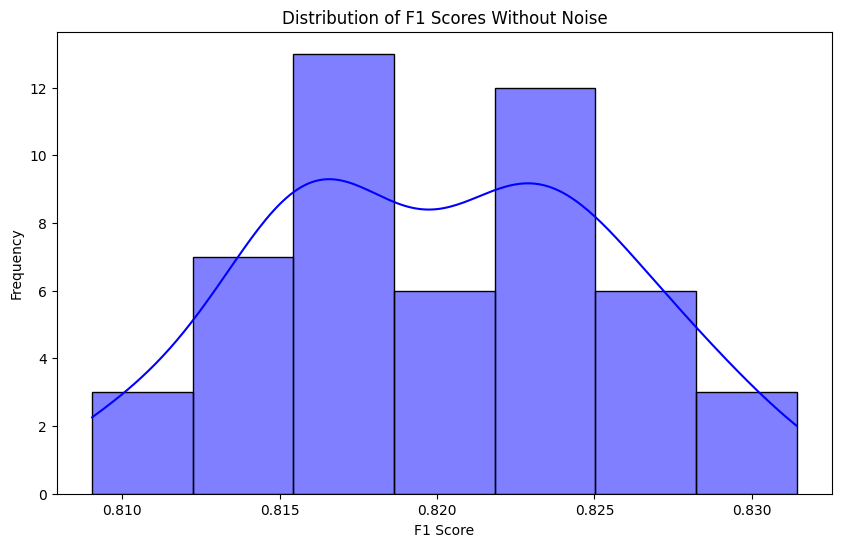

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns


# Create the plot
plt.figure(figsize=(10, 6))
sns.histplot(f1_scores_wo_noise, kde=True, color='blue')
plt.title('Distribution of F1 Scores Without Noise')
plt.xlabel('F1 Score')
plt.ylabel('Frequency')
plt.show()

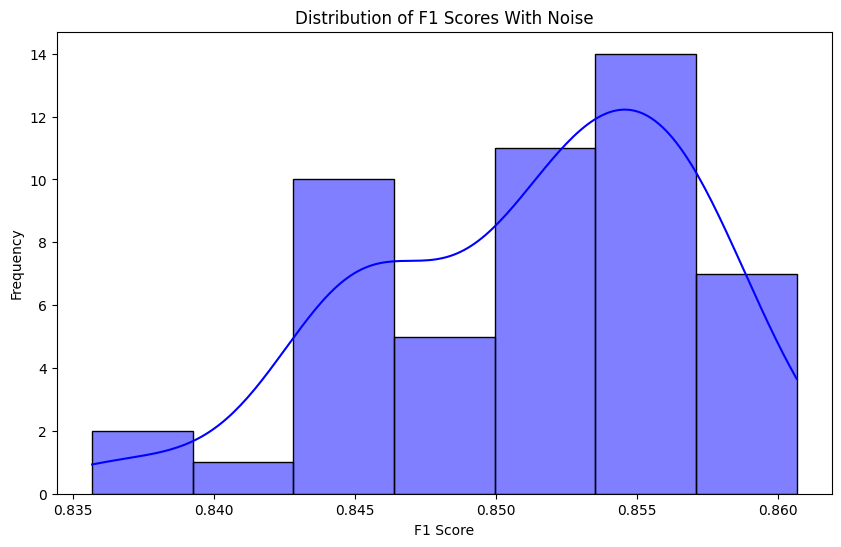

In [62]:
# Create the plot
plt.figure(figsize=(10, 6))
sns.histplot(f1_scores_w_noise, kde=True, color='blue')
plt.title('Distribution of F1 Scores With Noise')
plt.xlabel('F1 Score')
plt.ylabel('Frequency')
plt.show()

In [65]:
from scipy import stats
print("Normality Check (Noisy):", stats.shapiro(f1_scores_with_noise))
print("Normality Check (Noise-reduced):", stats.shapiro(f1_scores_wo_noise))

Normality Check (Noisy): ShapiroResult(statistic=0.9490898251533508, pvalue=0.031304486095905304)
Normality Check (Noise-reduced): ShapiroResult(statistic=0.9749072194099426, pvalue=0.36198413372039795)


In [66]:
from scipy.stats import shapiro

# List of F1 scores without noise
f1_scores_wo_noise = [
    0.8161412208480111, 0.8128891146350268, 0.8160396790031451, 0.8234990801422082,
    0.8314274334257702, 0.8165630629591611, 0.8199598347596834, 0.8231473431980911,
    0.8209683397040348, 0.8239281852143301, 0.8261915132885501, 0.814743764039385,
    0.8181815820808266, 0.8208294409769049, 0.8151074049760086, 0.8173291253687829,
    0.8238363079180913, 0.8171072365862403, 0.8169625717151903, 0.8157859771364823,
    0.8281441681956397, 0.8162398847040109, 0.8090407018895505, 0.8246766811308877,
    0.8225428155944076, 0.8237134646577, 0.8217679541878669, 0.812340800082993,
    0.828991308331433, 0.8148219538779382, 0.8272358300705547, 0.8102650752221228,
    0.8264028022423867, 0.8163246085303311, 0.829694476830559, 0.82775175629694,
    0.8234976387472875, 0.8094928244803721, 0.8239460118741528, 0.814137674743434,
    0.8168882103561063, 0.8126984244933501, 0.824054081922743, 0.8167263592689784,
    0.8165988695422391, 0.8222140848940257, 0.8264959865230648, 0.8207680061268628,
    0.8221299579697526, 0.8214169966458367
]

# Perform Shapiro-Wilk test
shapiro_results = shapiro(f1_scores_wo_noise)
shapiro_results

ShapiroResult(statistic=0.9749072194099426, pvalue=0.36198413372039795)